In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from scipy.spatial import distance
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
rainfall_data = pd.read_excel('D:\\Intern\\WECS_raw_combined.xlsx','filter',index_col = 'Date', parse_dates = True)

In [13]:
rainfall_data

,101,102,103,104,105,106,107,108
Date,,,,,,,,
1980-01-01,0.8,7.5,0.0,0.0,0.0,0.0,0.0,7.0
1980-01-02,0.0,2.6,0.2,6.8,4.2,3.5,33.0,8.4
1980-01-03,0.0,0.0,0.0,9.4,2.0,0.0,0.0,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2018-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
rainfall_data = rainfall_data.loc['1980-01-01':'2017-12-31']

In [15]:
rainfall_data.columns = rainfall_data.columns.astype(str)

In [16]:
# Apply KNN imputation to handle missing values
imputer = SimpleImputer(strategy='mean')
rainfall_data_imputed = pd.DataFrame(imputer.fit_transform(rainfall_data), columns=rainfall_data.columns, index=rainfall_data.index)


In [17]:
rainfall_data_imputed

,101,102,103,104,105,106,107,108
Date,,,,,,,,
1980-01-01,0.8,7.5,0.0,0.0,0.0,0.0,0.0,7.0
1980-01-02,0.0,2.6,0.2,6.8,4.2,3.5,33.0,8.4
1980-01-03,0.0,0.0,0.0,9.4,2.0,0.0,0.0,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2017-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
def lat_lon_to_cartesian(lat, lon, radius=6371):
    lat, lon = np.radians(lat), np.radians(lon)
    x = radius * np.cos(lat) * np.cos(lon)
    y = radius * np.cos(lat) * np.sin(lon)
    z = radius * np.sin(lat)
    return np.array([x, y, z])

In [19]:
coords = pd.read_excel('D:\\Intern\\Station Metadata (1) (1).xlsx') # import coordinates of stations
# Extract coordinates
stations = coords['Statin Index No.'].values
x_coords = coords['Lat'].values
y_coords = coords['Lon'].values
elevations = coords['Elev'].values

In [20]:
stations = stations[~np.isnan(stations)]
stations = stations.astype(int)

In [21]:
station_data = {station: (x, y, z) for station, x, y, z in zip(stations, x_coords, y_coords, elevations)}
filtered_station_data = {station: station_data[int(station)] for station in rainfall_data.columns if int(station) in station_data}


In [22]:
stations = np.array(list(filtered_station_data.keys()))
x_coords = np.array([filtered_station_data[station][0] for station in stations])
y_coords = np.array([filtered_station_data[station][1] for station in stations])
elevations = np.array([filtered_station_data[station][2] for station in stations])


In [23]:
station_positions = np.array([lat_lon_to_cartesian(x, y) for x, y in zip(x_coords, y_coords)])
num_stations = len(station_positions)
dist_matrix = np.zeros((num_stations, num_stations))

In [24]:
for i in range(num_stations):
    for j in range(i, num_stations):  # Only compute half the matrix (symmetric)
        dist = distance.euclidean(station_positions[i], station_positions[j])
        dist_matrix[i][j] = dist
        dist_matrix[j][i] = dist

In [25]:
dist_matrix

array([[  0.        ,  16.48303396,  21.26423978,  39.97576255,
         83.71944601, 107.87378606,  20.77181334,  18.32662249],
       [ 16.48303396,   0.        ,  16.29151666,  33.11701108,
         69.31719074,  95.5704172 ,  34.42695738,  10.54275152],
       [ 21.26423978,  16.29151666,   0.        ,  18.87879496,
         64.66886228,  87.04774154,  42.01160547,   5.7568306 ],
       [ 39.97576255,  33.11701108,  18.87879496,   0.        ,
         51.85893252,  70.13403643,  60.58510234,  23.48055928],
       [ 83.71944601,  69.31719074,  64.66886228,  51.85893252,
          0.        ,  31.79284035, 103.57744011,  65.65177608],
       [107.87378606,  95.5704172 ,  87.04774154,  70.13403643,
         31.79284035,   0.        , 128.53135553,  89.60051743],
       [ 20.77181334,  34.42695738,  42.01160547,  60.58510234,
        103.57744011, 128.53135553,   0.        ,  38.93490776],
       [ 18.32662249,  10.54275152,   5.7568306 ,  23.48055928,
         65.65177608,  89.6005174

In [26]:
# Find the nearest 8 neighbors for each station
nearest_neighbors = {}
for i, station in enumerate(stations):
    dists = dist_matrix[i]
    nearest_indices = dists.argsort()[1:9]# Exclude the station itself and take the nearest 8
    nearest_stations = [stations[j] for j in nearest_indices]
    nearest_neighbors[station] = [stations[j] for j in nearest_indices]


In [27]:
nearest_neighbors

{'101': ['102', '108', '107', '103', '104', '105', '106'],
 '102': ['108', '103', '101', '104', '107', '105', '106'],
 '103': ['108', '102', '104', '101', '107', '105', '106'],
 '104': ['103', '108', '102', '101', '105', '107', '106'],
 '105': ['106', '104', '103', '108', '102', '101', '107'],
 '106': ['105', '104', '103', '108', '102', '101', '107'],
 '107': ['101', '102', '108', '103', '104', '105', '106'],
 '108': ['103', '102', '101', '104', '107', '105', '106']}

In [28]:
#Encoding the cyclical properties of time
def date_features(df, inplace=False):
    if not inplace:
        df = df.copy()
    df.index = pd.to_datetime(df.index)
    df['day_sin'] = np.sin(df.index.dayofyear*(2.*np.pi/365))
    df['day_cos'] = np.cos(df.index.dayofyear*(2.*np.pi/365))
    df['month_sin'] = np.sin(df.index.month*(2.*np.pi/12))
    df['month_cos'] = np.cos(df.index.month*(2.*np.pi/12))
    if not inplace:
        return df

In [29]:
date_features(rainfall_data_imputed, inplace=True)

In [30]:
rainfall_data_imputed

,101,102,103,104,105,106,107,108,day_sin,day_cos,month_sin,month_cos
Date,,,,,,,,,,,,
1980-01-01,0.8,7.5,0.0,0.0,0.0,0.0,0.0,7.0,1.721336e-02,0.999852,5.000000e-01,0.866025
1980-01-02,0.0,2.6,0.2,6.8,4.2,3.5,33.0,8.4,3.442161e-02,0.999407,5.000000e-01,0.866025
1980-01-03,0.0,0.0,0.0,9.4,2.0,0.0,0.0,0.0,5.161967e-02,0.998667,5.000000e-01,0.866025
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.880243e-02,0.997630,5.000000e-01,0.866025
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.596480e-02,0.996298,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.880243e-02,0.997630,-2.449294e-16,1.000000
2017-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.161967e-02,0.998667,-2.449294e-16,1.000000
2017-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.442161e-02,0.999407,-2.449294e-16,1.000000


In [33]:
results = {}
specific_columns = ['101','102']

Predicting for station: 101


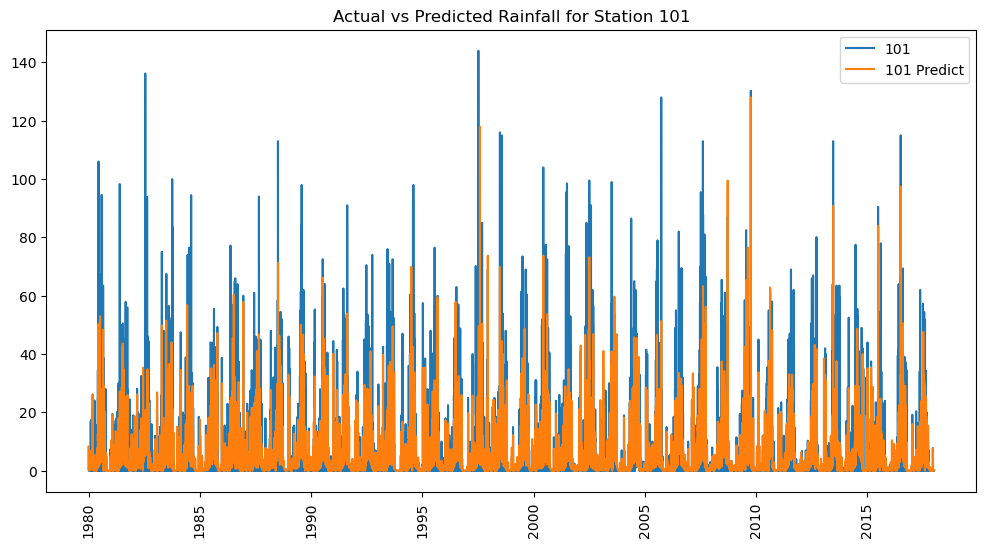

Predicting for station: 102


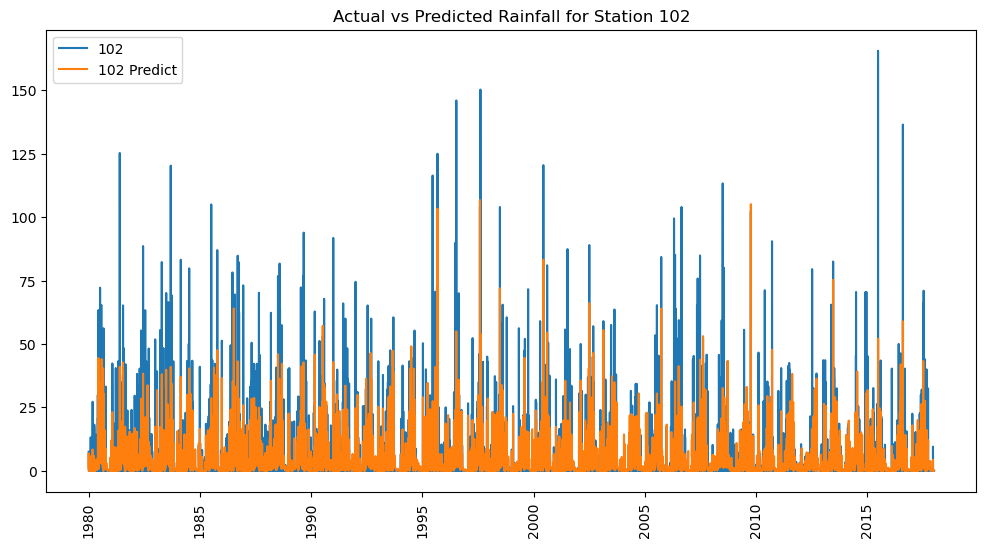

In [36]:
for target_station in specific_columns:
    print(f"Predicting for station: {target_station}")
    
    target = rainfall_data[target_station]
    
    neighbors = nearest_neighbors[target_station]
    neighbor_cols = [str(neighbor) for neighbor in neighbors]
    
    
    features = rainfall_data_imputed[neighbor_cols + ['day_sin', 'day_cos', 'month_sin', 'month_cos']]
    
    # Splitting into training and missing data
    mask = target.notna()
    xTrain = features[mask]
    yTrain = target[mask]
    
    scaler = StandardScaler().fit(xTrain.values)
    xTrainScaled = scaler.transform(xTrain.values)
    
    regr = MLPRegressor(random_state=1, max_iter=5000).fit(xTrainScaled, yTrain)
    
    xPredict = scaler.transform(features.values)
    yPredict = regr.predict(xPredict)
    
    
    yPredict = np.maximum(yPredict, 0)
    
    # Fill missing values in the original data
    target_filled = target.copy()
    target_filled.loc[~mask] = yPredict[~mask]
    rainfall_data.loc[:, target_station] = target_filled

    # Filter yPredict to only non-missing values for MAE and RMSE calculation
    yPredict_non_missing = yPredict[mask]
    
    mae = mean_absolute_error(yTrain, yPredict_non_missing)
    rmse = np.sqrt(mean_squared_error(yTrain, yPredict_non_missing))
    
    
    results[target_station] = {
        'MAE': mae,
        'RMSE': rmse
    }
    
    
    plt.figure(figsize=(12, 6))
    plt.plot(rainfall_data.index, rainfall_data[target_station], label=f'{target_station}')
    plt.plot(xTrain.index, yPredict, label=f'{target_station} Predict')
    plt.legend()
    plt.xticks(rotation='vertical')
    plt.title(f'Actual vs Predicted Rainfall for Station {target_station}')
    plt.show()
    
    
    
    


In [37]:
for station, metrics in results.items():
    print(f"Station {station}:")
    print(f"  Mean Absolute Error (MAE): {metrics['MAE']}")
    print(f"  Root Mean Squared Error (RMSE): {metrics['RMSE']}")
    print()

Station 101:
  Mean Absolute Error (MAE): 4.159978834443967
  Root Mean Squared Error (RMSE): 8.88869910687123

Station 102:
  Mean Absolute Error (MAE): 3.5048471851887943
  Root Mean Squared Error (RMSE): 7.758901434176006



In [29]:
results

{'101': {'MAE': 4.224239926869899, 'RMSE': 8.897707869167482},
 '102': {'MAE': 3.7770741899918083, 'RMSE': 8.330608477333254},
 '103': {'MAE': 2.8947091503913915, 'RMSE': 6.827999693263542},
 '104': {'MAE': 2.7603883512005067, 'RMSE': 6.58924262693768},
 '105': {'MAE': 5.48093445650399, 'RMSE': 12.710672114728128},
 '106': {'MAE': 4.809024845886249, 'RMSE': 12.472210721277524},
 '107': {'MAE': 5.32864450142268, 'RMSE': 10.810727721309856},
 '108': {'MAE': 3.37450353795165, 'RMSE': 7.973558647108649}}

In [38]:
rainfall_data

,101,102,103,104,105,106,107,108
Date,,,,,,,,
1980-01-01,0.8,7.5,0.0,0.0,0.0,0.0,0.0,7.0
1980-01-02,0.0,2.6,0.2,6.8,4.2,3.5,33.0,8.4
1980-01-03,0.0,0.0,0.0,9.4,2.0,0.0,0.0,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2017-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
rainfall_data.isna().sum()

101       0
102       0
103      29
104       0
105    2271
106       0
107       0
108      30
dtype: int64